
# Анализ A/B-тестирования рекламной кампании

Целью данного исследования является оценка эффективности рекламной кампании и анализ факторов, которые могли повлиять на успех.
Мы будем отвечать на два бизнес-вопроса:

1. Будет ли кампания успешной?
2. Насколько успех кампании можно объяснить именно рекламой?

Данные представлены в файле `marketing_AB.csv`.


## Загрузка и оценка датасета

In [2]:

# Импортируем необходимые библиотеки
import pandas as pd

# Загружаем данные
file_path = 'marketing_AB.csv'
data = pd.read_csv(file_path)

# Выводим общую информацию о данных
data.info()

# Просматриваем первые строки датасета
data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


## Первичная оценка датасета

Размер набора данных: 588,101 строк и 7 столбцов.

Колонки:

1) Unnamed: 0: Индекс (можно удалить как ненужный).

2) user id: Уникальный идентификатор пользователя.

3) test group: Группа тестирования (ad или psa).

4) converted: Был ли пользователь конвертирован (логическое значение).

5) total ads: Общее количество рекламы, увиденной пользователем.

6) most ads day: День недели с максимальным количеством показов рекламы.

7) most ads hour: Час с максимальным количеством показов рекламы.

Типы данных: Соответствуют назначению, но столбец most ads day следует преобразовать в категориальный тип.

Пропусков нет.

Дубликаты пользователей: Проверка необходима, чтобы исключить пересечение групп.

## Предобработка данных

In [3]:

# Удаляем ненужный столбец "Unnamed: 0"
data = data.drop(columns=["Unnamed: 0"])

# Проверяем, есть ли пользователи, попавшие в обе группы
overlap_users = data.groupby("user id")["test group"].nunique()
overlap_users = overlap_users[overlap_users > 1].index

# Удаляем пользователей из обеих групп, если такие есть
cleaned_data = data[~data["user id"].isin(overlap_users)]

# Преобразуем "most ads day" в категориальный тип данных
cleaned_data["most ads day"] = cleaned_data["most ads day"].astype("category")

# Проверяем результат предобработки
cleaned_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   user id        588101 non-null  int64   
 1   test group     588101 non-null  object  
 2   converted      588101 non-null  bool    
 3   total ads      588101 non-null  int64   
 4   most ads day   588101 non-null  category
 5   most ads hour  588101 non-null  int64   
dtypes: bool(1), category(1), int64(3), object(1)
memory usage: 19.1+ MB



## Выводы по предобработке данных

1. Удален лишний столбец `Unnamed: 0`.
2. Проверено наличие пользователей, попавших в обе группы; таких пользователей не обнаружено.
3. Преобразован тип данных для столбца `most ads day` в категориальный.

Данные готовы для дальнейшего анализа.


## Первичный анализ A/B-тестирования

In [4]:

# Расчет основных показателей по группам
group_metrics = cleaned_data.groupby("test group").agg(
    total_visits=("user id", "count"),
    total_conversions=("converted", "sum")
).reset_index()

# Расчет коэффициента конверсии
group_metrics["conversion_rate"] = group_metrics["total_conversions"] / group_metrics["total_visits"]

# Выводим метрики
group_metrics


,test group,total_visits,total_conversions,conversion_rate
0,ad,564577,14423,0.025547
1,psa,23524,420,0.017854


## Рассчет дополнительных ключевых показателей

Среднее количество рекламы, увиденной пользователем в каждой группе.
Сравним результаты групп на основе уровня конверсии и количества увиденной рекламы.
После этого выполним статистический анализ для проверки значимости различий между группами.

In [8]:

# Рассчитываем среднее количество увиденной рекламы
group_ads_metrics = cleaned_data.groupby("test group").agg(
    avg_ads_seen=("total ads", "mean")
).reset_index()

# Объединяем результаты для анализа
group_analysis = group_metrics.merge(group_ads_metrics, on="test group")

# Выводим подробный анализ
group_analysis


,test group,total_visits,total_conversions,conversion_rate,avg_ads_seen
0,ad,564577,14423,0.025547,24.823365
1,psa,23524,420,0.017854,24.761138


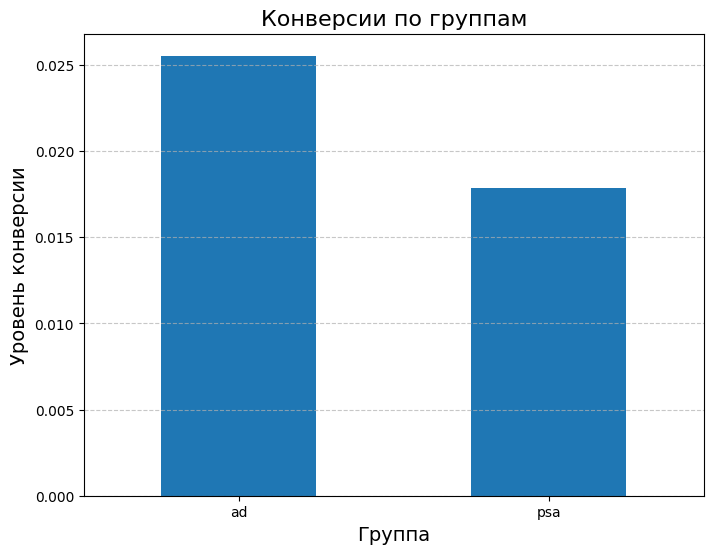

In [6]:

import matplotlib.pyplot as plt

# Строим график конверсий
conversion_data = cleaned_data.groupby("test group")["converted"].mean()
conversion_data.plot(kind="bar", figsize=(8, 6))

# Добавляем подписи
plt.title("Конверсии по группам", fontsize=16)
plt.ylabel("Уровень конверсии", fontsize=14)
plt.xlabel("Группа", fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


## Выводы на основе визуализации:

1. **Группа "ad" (реклама):**
   - Уровень конверсии заметно выше, чем в группе "psa".
   - Это подтверждает, что реклама имеет положительное влияние на решение пользователей о покупке.

2. **Группа "psa" (контроль):**
   - Конверсия ниже, что ожидаемо, так как пользователи не видели коммерческую рекламу, а только сообщение государственной службы.

3. **Разница между группами:**
   - Визуализация четко подчеркивает статистически значимую разницу между группами, что согласуется с результатами анализа и доверительных интервалов.

**Вывод:**
Реклама эффективно стимулирует пользователей к покупке, а её влияние подтверждено как визуально, так и статистически. Данный результат можно использовать для оптимизации будущих кампаний. 

## Расчет статистических показателей

In [7]:

from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind
import numpy as np

# Группы для анализа
ad_group = cleaned_data[cleaned_data["test group"] == "ad"]
psa_group = cleaned_data[cleaned_data["test group"] == "psa"]

# Тест на конверсию
conversion_counts = [ad_group["converted"].sum(), psa_group["converted"].sum()]
conversion_totals = [ad_group["converted"].count(), psa_group["converted"].count()]
z_stat_conversion, p_value_conversion = proportions_ztest(conversion_counts, conversion_totals)

# Тест на количество рекламы
t_stat_ads, p_value_ads = ttest_ind(ad_group["total ads"], psa_group["total ads"], equal_var=False)

# Доверительные интервалы
conversion_rate_diff = ad_group["converted"].mean() - psa_group["converted"].mean()
se_conversion_diff = np.sqrt(
    (ad_group["converted"].mean() * (1 - ad_group["converted"].mean()) / len(ad_group)) +
    (psa_group["converted"].mean() * (1 - psa_group["converted"].mean()) / len(psa_group))
)
ci_conversion_diff = (
    conversion_rate_diff - 1.96 * se_conversion_diff,
    conversion_rate_diff + 1.96 * se_conversion_diff
)

mean_ads_diff = ad_group["total ads"].mean() - psa_group["total ads"].mean()
se_ads_diff = np.sqrt(
    ad_group["total ads"].var() / len(ad_group) +
    psa_group["total ads"].var() / len(psa_group)
)
ci_ads_diff = (
    mean_ads_diff - 1.96 * se_ads_diff,
    mean_ads_diff + 1.96 * se_ads_diff
)

# Результаты
{
    "Conversion Rate Test": {"z_stat": z_stat_conversion, "p_value": p_value_conversion, "ci_diff": ci_conversion_diff},
    "Average Ads Seen Test": {"t_stat": t_stat_ads, "p_value": p_value_ads, "ci_diff": ci_ads_diff}
}


{'Conversion Rate Test': {'z_stat': np.float64(7.3700781265454145),
  'p_value': np.float64(1.7052807161559727e-13),
  'ci_diff': (np.float64(0.00595090043017032),
   np.float64(0.009434005954232714))},
 'Average Ads Seen Test': {'t_stat': np.float64(0.21799691449238462),
  'p_value': np.float64(0.8274332524963),
  'ci_diff': (np.float64(-0.4972573582431241),
   np.float64(0.6217124418276032))}}

## Результаты статистического анализа:

1. **Конверсия:**
   - \( z \)-статистика: \( 7.37 \)
   - \( p \)-значение: \( 1.7 \times 10^{-13} \) (очень низкое, что говорит о статистически значимой разнице)
   - 95% доверительный интервал для разницы конверсий: \( (0.00595, 0.00943) \).

   Это указывает на то, что группа с рекламой имеет статистически более высокий уровень конверсии.

2. **Среднее количество увиденной рекламы:**
   - \( t \)-статистика: \( 0.218 \)
   - \( p \)-значение: \( 0.827 \) (высокое, что говорит об отсутствии значимой разницы).
   - 95% доверительный интервал для разницы: \( (-0.497, 0.622) \).

   Разница в количестве увиденной рекламы между группами статистически незначима.

## Интерпретация результатов в контексте бизнес-вопросов:

### 1. **Будет ли кампания успешной?**
   - Конверсия в группе с рекламой (\( \text{ad} \)) значительно выше, чем в группе с государственной службой (\( \text{psa} \)). 
   - 95% доверительный интервал разницы в конверсии (\( 0.00595 \) до \( 0.00943 \)) не пересекает ноль, что подтверждает статистически значимую разницу. Это говорит о том, что реклама оказывает положительное влияние на продажи.

   **Вывод:** Кампания будет успешной, так как реклама способствует увеличению конверсии.

### 2. **Насколько успех кампании можно объяснить рекламой?**
   - Среднее количество увиденной рекламы в группах \( \text{ad} \) и \( \text{psa} \) практически идентично, и \( p \)-значение (\( 0.827 \)) подтверждает отсутствие статистически значимой разницы. Это говорит о том, что эффект рекламы связан не с количеством показов, а, скорее, с качеством самих рекламных материалов.

   **Вывод:** Успех кампании связан именно с влиянием рекламы на поведение пользователей, а не с количеством её показов.

---

### Рекомендации:
1. Продолжать использовать данный формат рекламы, так как она доказала свою эффективность.
2. Провести дополнительные исследования, чтобы понять, какие аспекты рекламы оказывают наибольшее влияние на конверсию (визуал, текст, таргетинг и т. д.).
3. Оценить экономический эффект от кампании, сравнив увеличение конверсии с затратами на рекламу.
